In [1]:
from PIL import Image, ImageDraw
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

import cv2
import matplotlib.pyplot as plt

import time

# gen images
IMG_X, IMG_Y = 200,200 
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

# img_list = []

In [92]:
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = './' + dirname  
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        #orient = 0 # degrees
        img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

        # block_l and _w offset so blocks don't run off edge of image 
        rand_x = int(np.random.rand() * (IMG_X-2*block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y-2*block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient) # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                        rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill='white')

        # use a truetype font
        #font = imagefont.truetype("dejavusans.ttf", 15)
        #font = imagefont.truetype("arial.ttf",14)
        #idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')
        img.save(newpath + '/rect'+str(i)+'.png')
    return true_coords

train_truth = make_dataset('data', 500)
print(len(train_truth))
test_truth = make_dataset('./data/test', 300)

np.save('train_truth.npy', train_truth)
np.save('test_truth.npy', test_truth)


class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform
        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        MARGIN_PX = 10
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.detectMargin = MARGIN_PX

    def __len__(self):
        #print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png')
        image = torch.FloatTensor(image).permute(
            2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        crops, labels = self.makeCrops(image, self.step, self.cropSize, coords,
                                       self.detectMargin)

        #sample = {'crops': crops, 'labels': labels}
        return crops, labels

    def makeCrops(self, image, stepSize, windowSize, rectCenter, detectMargin):
        """
        Returns image crops, as well as T/F for those crops 
        """
        crops = []
        #print(rectCenter)
        c_x, c_y, theta = rectCenter
        margin = detectMargin
        truths = []
        # TODO : look into why it's y,x !
        print('image type in crops', type(image))
        for x in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for y in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[0], y + windowSize[1]
                hasRect = (x + margin < c_x < end_x - margin) and \
                    (y + margin < c_y < end_y - margin)
                crops.append(image[y:end_y, x:end_x])
                truths.append(hasRect)
        return crops, truths

500


(500, 3)
[ 56.        131.          0.2443461]
200 200


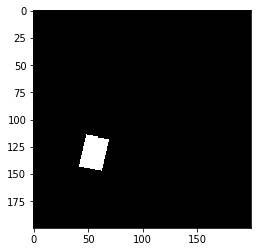

In [93]:
# Read in Images
train_truth = np.load('train_truth.npy')# loading the training and testing data
test_truth = np.load('test_truth.npy')# loading the training and testing data
print(train_truth.shape)
print(train_truth[1])

#from IPython.display import Image, display
foo_image = io.imread('./data'+ '/rect'+str(1)+'.png')
plt.imshow(foo_image)
print(IMG_X, IMG_Y)
#plt.imshow(foo_image[100:200, 100:200]o)

In [94]:
# Hyper parameters
num_epochs = 10 
num_classes = 3 # predicting x,y,orientation
learning_rate = 0.001
batch_size = 15 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
print(len(train_dataset))

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir='./data/test', coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)



CUDA available? device:  cuda:0
500


In [95]:

class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        """ We need the image width and height to determine CNN layer sizes
        """
        super(Net, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        # self.numCrops = 0
        # T/F for now

        # calculate number of crops
        # for y in range(0, IMG_Y, STEPSIZE):
        #    for x in range(0, IMG_X, STEPSIZE):
        #        self.numCrops += 1
        # TODO: but our net wants everything to be the same size... pad with 0s?

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers
        # print(self._const)
        self._const = int(self._const)

        # 3 input image channels (RGB)  .6 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, 1).to(device)
        # (* N crops, if we wanted output for all # windows at once)
        # TODO: batch normalization  self.bn = nn.BatchNorm2d()

    #
        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        # self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        # Class prediction convolutions (predict classes in localization boxes)
        # self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
    def forward(self, x):
        # print(x.size())
        #x = x.to(device)
        crops = self.makeCrops(x, self.step, self.cropSize)
        box_class_scores = []
        for img in crops:
            #print(img.shape)
            x = img.view(-1, 3, self.cropSize[0], self.cropSize[1])
            x = self.pool(F.relu((self.conv1(x))))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, self._const)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            box_class_scores.append(x)
        return box_class_scores
        # TODO: maybe the last layer should have ReLu or softmax for binary?  # vs multiple classes
        # TODO: should we run the windows through as a concat, or let the net
        # learn from every individual window? prolly the latter

    def makeCrops(self, image, stepSize, windowSize):
        """
        Returns a generator of cropped boxes (the top left x,y, the image data)
        """
        crops = []
        # TODO: look into ordering, why it's y,x !
        for x in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for y in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[0], y + windowSize[1]
                crops.append(image[x:end_x, y:end_y])
        # self.numCrops=len(crops)
        return crops



    
model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
losses_list = []
ct = 0
print('Training model now...')
total_step = len(train_loader)
tstart = time.time()
for epoch in range(num_epochs):
    for i_batch, (images, labels) in enumerate(train_loader):
        #slidow_coords(images)
        
        #prediction = blah

        print('labels', type(labels), labels)
        print('images', type(images), images)
        images = [img.to(device) for img in images]
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        #if (i_batch+1) % 1 == 0:
        if (epoch+1) % 10 == 0:
            print('Time since start: ', time.time() - tstart)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1,
                                                                      num_epochs,
                                                                      i_batch+1,
                                                                      total_step,
                                                                      loss.item()))
        losses_list.append(loss.item())
        
#windowGenerator = slidow_coords(foo_image, 50, (100,100), (45,101), MARGIN_PX)

#MARGIN_PX = 10
#for i, foo in enumerate(windowGenerator):
    #x,y,img, hasRect = foo
    #print("1-index number of window: ", i+1, 'x', x, 'y', y, 'has rectangle?', hasRect)
    #plt.figure()
    #plt.imshow(img)

Training model now...
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
image type i ncrops <class 'torch.Tensor'>
labels <class 'list'> []
images <class 'list'> []


AttributeError: 'list' object has no attribute 'shape'